# WFSS Box Extraction Example

This notebook demonstrates how to use the Generalized World Coordinate System (gWCS) in a Wide Field Slitless Spectrscopy (WFSS) observation to determine source locations and wavelengths. It shows how to calculate the location of a source in a WFSS observation given its location in a corresponding imaging observation, and how to calculate the wavelength at a particular pixel along an object's trace.

It then shows how to use the gWCS to perform a box extraction of a spectrum and translate the 1D spectrum into physical units.

In this example, we use exposures from JWST program 01076. We want to work on files that have full gWCS information in their headers, and that have had the flat field applied. We also need to run the flux calibration step of the pipeline in order to populate the name of the photom reference file in the header of the WFSS file (in the S_PHOTOM header keyword). This reference file will be used as part of the extraction process below. The photom step will not change the values of the science data in the WFSS exposure, because the observing mode (OBS_MODE header keyword) in the file is set to NRC_WFSS.

In order to accomplish this, the <b>assign_wcs</b>, <b>flat field</b>, and <b>photom</b> steps of the pipeline must be run on the data. Ordinarily this means we could simply download *_cal.fits files from MAST, and that is true for the imaging mode data used in this notebook. However as we show below, we want to apply the imaging mode flat field to the WFSS data. This means that we must download the *_rate.fits file, and manually run these pipeline steps on the data. For consistency, we do the same with the imaging mode data.

JWST detectors show little to no wavelength dependence in their flat-field, and just as is regularly done with HST WFSS data, in this example we have the pipeline apply the flat field for the direct cross filter to all the imaging as well as WFSS observations. We do not use a WFSS-specific flat field.

Once the data have been properly calibrated, the notebook uses the <b>grismconf</b> package to translate between source locations in the imaging and WFSS data, and calculate wavelengths associated with a given location in the WFSS data. <b>grismconf</b> also uses the flux calibration curve in the photom reference file for the grisms to translate the data from units of $DN/sec$ to $F_{lambda}$ units ($erg / sec / cm^2 / \overset{\circ}{A}$). <b>grismconf</b> will obtain the needed NIRCam WFSS configuration files from the Calibration Reference Data System (CRDS). Note that the photom step must be run on the data in order to obain the name of the approproate CRDS sesitivity file.

Note: At this stage, the important part of this is not the absolute accuracy of the WCS. Instead, we rely on accurate self-consistency between the imaging and the WFSS observations. 

Author: N. Pirzkal <br>
Date created: 24 Sept 2024

## Table of Contents
1. [Package Imports](#Package-Imports)
2. [Define Functions and Parameters](#Define-Functions-and-Parameters)
3. [Download Data](#Download-Data)
4. [Run Pipeline Steps](#Run-Pipeline-Steps)
5. [Basic Computation of WFSS Information](#Basic-Computation-of-WFSS-Information)
      * [Compute where light gets dispersed to](#Compute-where-light-gets-dispersed-to)
      * [Compute the spectral trace for a given object](#Compute-the-spectral-trace-for-a-given-object)
      * [Basic Box Extraction](#Basic-Box-Extraction)

## Package Imports

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from scipy.stats import sigmaclip

import grismconf
from jwst.assign_wcs import AssignWcsStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep

## Set CRDS Path and Server

Before running the pipeline steps, we need to ensure our our CRDS environment is configured. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache has not already been set, it will be created in the home directory.

In [2]:
# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path and context in use
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

# import crds after setting up the required environment variables
from crds import client
if client.get_crds_server() != os.environ['CRDS_SERVER_URL']:
    client.set_crds_server('https://jwst-crds.stsci.edu')

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


## Define Functions and Parameters

Define a function to download a named file via the MAST API to the current directory. The function includes authentication logic, but the example in this notebook uses public data, so no MAST API token is required.

In [3]:
def get_jwst_file(name, mast_api_token=None, overwrite=False):
    """Retrieve a JWST data file from MAST archive.
    
    Parameters
    ----------
    name : str
        Name of the file to download from MAST
        
    mast_api_token : str
        MAST API token. Required only for proprietary data
        
    overwrite : bool
        If True and the requested file already exists locally, the file will not be downloaded. IF False,
        the file will be downloaded
    """
    # If the file already exists locally, don't redownload it, unless the
    # user has set the overwrite keyword
    if os.path.isfile(name):
        if not overwrite:
            print(f'{name} already exists locally. Skipping download.')
            return
        else:
            print(f'{name} exists locally. Re-downloading.')

    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Define a function that will run assign_wcs and flat fielding on an input rate file

In [4]:
def run_pipeline_steps(filename):
    """Run the assign_wcs, flat field, and photom calibration steps on the given file.
    If the file contains WFSS data, trick the pipeline to use the imaging mode flat
    field reference file.
    
    Parameters
    ----------
    filename : str
        Name of the input file upon which the steps will be run
        
    Returns
    -------
    filename : str
        Name of the output file saved by the pipeline steps
        
    photom : jwst.datamodels.ImageModel
        Datamodel instance containing the calibrated data
    """
    assign_wcs = AssignWcsStep.call(filename)

    # In order to apply the imaging mode flat field reference file to the data,
    # we need to trick CRDS by temporarily changing the pupil value to be CLEAR
    reset_pupil = False
    if 'GRISM' in assign_wcs.meta.instrument.pupil:
        true_pupil = deepcopy(assign_wcs.meta.instrument.pupil)
        assign_wcs.meta.instrument.pupil = 'CLEAR'
        reset_pupil = True

    # Run the flat field step
    flat = FlatFieldStep.call(assign_wcs, save_results=True)
    
    # Run the photom step to populate the name of the WFSS sensitivity 
    photom = PhotomStep.call(flat, save_results=True)
    
    # Set the pupil back to the original value now that flat fielding is complete
    if reset_pupil:
        photom.meta.instrument.pupil = true_pupil
        photom.save(photom.meta.filename)
    
    # Return the name of the output file, as well as the datamodel
    return photom.meta.filename, photom

## Download Data

Download an example imaging mode rate file and corresponding WFSS mode rate file from MAST.

In [5]:
# First, download the imaging and WFSS files from MAST
imaging_file = "jw01076103001_02102_00001_nrcalong_rate.fits"
wfss_file = "jw01076103001_02101_00001_nrcalong_rate.fits"
get_jwst_file(imaging_file)
get_jwst_file(wfss_file)

## Run Pipeline Steps

Run the assign_wcs, flat field, and photom calibration steps on both the imaging and WFSS files.

In [6]:
# Run AssignWcsStep, FlatFieldStep, and PhotomStep on the imaging rate file
imaging_flat_file, imaging_data = run_pipeline_steps(imaging_file)

2025-05-15 13:33:29,310 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


2025-05-15 13:33:29,610 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-05-15 13:33:29,807 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-05-15 13:33:29,988 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0047.imap        385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-05-15 13:33:30,065 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-05-15 13:33:30,223 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-05-15 13:33:30,355 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-05-15 13:33:30,486 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-05-15 13:33:30,561 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-05-15 13:33:30,800 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-05-15 13:33:30,963 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-05-15 13:33:31,068 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-05-15 13:33:31,153 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-05-15 13:33:31,280 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-05-15 13:33:31,415 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-05-15 13:33:31,500 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-05-15 13:33:31,585 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-05-15 13:33:31,685 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-05-15 13:33:31,766 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-05-15 13:33:31,855 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-05-15 13:33:31,934 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-05-15 13:33:32,025 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-05-15 13:33:32,103 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-05-15 13:33:32,186 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-05-15 13:33:32,264 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-05-15 13:33:32,406 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-05-15 13:33:32,499 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-05-15 13:33:32,609 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-05-15 13:33:32,683 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-05-15 13:33:32,758 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-05-15 13:33:32,840 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-05-15 13:33:32,919 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-05-15 13:33:32,994 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-05-15 13:33:33,072 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-05-15 13:33:33,159 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-05-15 13:33:33,235 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-05-15 13:33:33,328 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-05-15 13:33:33,409 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-05-15 13:33:33,560 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-05-15 13:33:33,667 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-05-15 13:33:33,777 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-05-15 13:33:33,875 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-05-15 13:33:33,972 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-05-15 13:33:34,050 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-05-15 13:33:34,132 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-05-15 13:33:34,209 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-05-15 13:33:34,295 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-05-15 13:33:34,395 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-05-15 13:33:34,476 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0398.imap     5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-05-15 13:33:34,550 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-05-15 13:33:34,652 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-05-15 13:33:34,729 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-05-15 13:33:34,808 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-05-15 13:33:34,884 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-05-15 13:33:34,960 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-05-15 13:33:35,036 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-05-15 13:33:35,130 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-05-15 13:33:35,211 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-05-15 13:33:35,298 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-05-15 13:33:35,376 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-05-15 13:33:35,458 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-05-15 13:33:35,541 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-05-15 13:33:35,632 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-05-15 13:33:35,711 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-05-15 13:33:35,787 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-05-15 13:33:35,862 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-05-15 13:33:35,937 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-05-15 13:33:36,019 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-05-15 13:33:36,099 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-05-15 13:33:36,177 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-05-15 13:33:36,257 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-05-15 13:33:36,338 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-05-15 13:33:36,426 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-05-15 13:33:36,503 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-05-15 13:33:36,582 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-05-15 13:33:36,673 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-05-15 13:33:36,758 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-05-15 13:33:36,840 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-05-15 13:33:36,919 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-05-15 13:33:36,997 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-05-15 13:33:37,153 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-05-15 13:33:37,233 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-05-15 13:33:37,327 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-05-15 13:33:37,414 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-05-15 13:33:37,492 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-05-15 13:33:37,582 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-05-15 13:33:37,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-05-15 13:33:37,813 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-05-15 13:33:37,889 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-05-15 13:33:37,964 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-05-15 13:33:38,066 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-05-15 13:33:38,144 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-05-15 13:33:38,243 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0272.imap      5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-05-15 13:33:38,332 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-05-15 13:33:38,432 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-05-15 13:33:38,595 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-05-15 13:33:38,676 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-05-15 13:33:38,765 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-05-15 13:33:38,863 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-05-15 13:33:38,953 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-05-15 13:33:39,038 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-05-15 13:33:39,120 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-05-15 13:33:39,213 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-05-15 13:33:39,306 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-05-15 13:33:39,401 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-05-15 13:33:39,480 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-05-15 13:33:39,557 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-05-15 13:33:39,636 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-05-15 13:33:39,717 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-05-15 13:33:39,799 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-05-15 13:33:39,883 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-05-15 13:33:39,968 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-05-15 13:33:40,051 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-05-15 13:33:40,148 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-05-15 13:33:40,226 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-05-15 13:33:40,311 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-05-15 13:33:40,397 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-05-15 13:33:40,484 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-05-15 13:33:40,568 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-05-15 13:33:40,651 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-05-15 13:33:40,739 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-05-15 13:33:40,819 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-05-15 13:33:40,912 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-05-15 13:33:40,993 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-05-15 13:33:41,085 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-05-15 13:33:41,168 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-05-15 13:33:41,274 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-05-15 13:33:41,367 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-05-15 13:33:41,458 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-05-15 13:33:41,536 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-05-15 13:33:41,615 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0314.imap      5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-05-15 13:33:41,703 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-05-15 13:33:41,782 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-05-15 13:33:41,864 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-05-15 13:33:41,948 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-05-15 13:33:42,032 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-05-15 13:33:42,116 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-05-15 13:33:42,195 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-05-15 13:33:42,281 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-05-15 13:33:42,357 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-05-15 13:33:42,435 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-05-15 13:33:42,515 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-05-15 13:33:42,604 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-05-15 13:33:42,694 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-05-15 13:33:42,768 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-05-15 13:33:42,845 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-05-15 13:33:42,920 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-05-15 13:33:43,002 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-05-15 13:33:43,088 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-05-15 13:33:43,169 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-05-15 13:33:43,248 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-05-15 13:33:43,323 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-05-15 13:33:43,403 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-05-15 13:33:43,482 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-05-15 13:33:43,560 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-05-15 13:33:43,638 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-05-15 13:33:43,727 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-05-15 13:33:43,801 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-05-15 13:33:43,894 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-05-15 13:33:43,972 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-05-15 13:33:44,056 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-05-15 13:33:44,151 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-05-15 13:33:44,242 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-05-15 13:33:44,319 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-05-15 13:33:44,403 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-05-15 13:33:44,495 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-05-15 13:33:44,587 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-05-15 13:33:44,675 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-05-15 13:33:44,752 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-05-15 13:33:44,836 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-05-15 13:33:44,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-05-15 13:33:44,994 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-05-15 13:33:45,077 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-05-15 13:33:45,171 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-05-15 13:33:45,252 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-05-15 13:33:45,336 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-05-15 13:33:45,412 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-05-15 13:33:45,497 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-05-15 13:33:45,576 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-05-15 13:33:45,651 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0437.imap        5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-05-15 13:33:45,727 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-05-15 13:33:45,804 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-05-15 13:33:45,883 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-05-15 13:33:45,963 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-05-15 13:33:46,045 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-05-15 13:33:46,127 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-05-15 13:33:46,207 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-05-15 13:33:46,291 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-05-15 13:33:46,371 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-05-15 13:33:46,446 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-05-15 13:33:46,536 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-05-15 13:33:46,658 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-05-15 13:33:46,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-05-15 13:33:46,825 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-05-15 13:33:46,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-05-15 13:33:47,009 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-05-15 13:33:47,083 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-05-15 13:33:47,157 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-05-15 13:33:47,233 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-05-15 13:33:47,306 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-05-15 13:33:47,408 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-05-15 13:33:47,487 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-05-15 13:33:47,559 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-05-15 13:33:47,635 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-05-15 13:33:47,722 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1364.pmap               580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-05-15 13:33:48,200 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2025-05-15 13:33:48,290 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('jw01076103001_02102_00001_nrcalong_rate.fits',).


2025-05-15 13:33:48,293 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  sip_approx: True
  sip_max_pix_error: 0.01
  sip_degree: None
  sip_max_inv_pix_error: 0.01
  sip_inv_degree: None
  sip_npoints: 12
  slit_y_low: -0.55
  slit_y_high: 0.55


2025-05-15 13:33:48,353 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0249.asdf   10.7 K bytes  (1 / 1 files) (0 / 10.7 K bytes)


2025-05-15 13:33:48,437 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_filteroffset_0007.asdf   11.4 K bytes  (1 / 1 files) (0 / 11.4 K bytes)


2025-05-15 13:33:48,745 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  247.881044388 30.207460875 247.843878110 30.191487022 247.861603517 30.159569797 247.899465303 30.174884151


2025-05-15 13:33:48,747 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  247.881044388 30.207460875 247.843878110 30.191487022 247.861603517 30.159569797 247.899465303 30.174884151


2025-05-15 13:33:48,747 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2025-05-15 13:33:48,800 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/opt/hostedtoolcache/Python/3.11.12/x64/lib/python3.11/site-packages/jwst-1.18.0.dist-info)


2025-05-15 13:33:48,900 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 13:33:48,901 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2025-05-15 13:33:48,902 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-15 13:33:48,918 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2025-05-15 13:33:49,004 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(2048, 2048) from jw01076103001_02102_00001_nrcalong_rate.fits>,).


2025-05-15 13:33:49,006 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_interpolated_flat: False
  user_supplied_flat: None
  inverse: False


2025-05-15 13:33:49,020 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0747.fits   50.4 M bytes  (1 / 1 files) (0 / 50.4 M bytes)


2025-05-15 13:33:52,848 - stpipe.FlatFieldStep - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0747.fits


2025-05-15 13:33:52,849 - stpipe.FlatFieldStep - INFO - No reference found for type FFLAT


2025-05-15 13:33:52,850 - stpipe.FlatFieldStep - INFO - No reference found for type SFLAT


2025-05-15 13:33:52,850 - stpipe.FlatFieldStep - INFO - No reference found for type DFLAT


2025-05-15 13:33:53,027 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 13:33:53,198 - stpipe.FlatFieldStep - INFO - Saved model in jw01076103001_02102_00001_nrcalong_flatfieldstep.fits


2025-05-15 13:33:53,199 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2025-05-15 13:33:53,200 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-15 13:33:53,217 - stpipe.PhotomStep - INFO - PhotomStep instance created.


2025-05-15 13:33:53,307 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<ImageModel(2048, 2048) from jw01076103001_02102_00001_nrcalong_flatfieldstep.fits>,).


2025-05-15 13:33:53,309 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: False
  source_type: None
  mrs_time_correction: True


2025-05-15 13:33:53,323 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits   23.0 K bytes  (1 / 1 files) (0 / 23.0 K bytes)


2025-05-15 13:33:53,440 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0334.fits   16.8 M bytes  (1 / 1 files) (0 / 16.8 M bytes)


2025-05-15 13:33:54,837 - stpipe.PhotomStep - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0157.fits


2025-05-15 13:33:54,838 - stpipe.PhotomStep - INFO - Using area reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_area_0334.fits


2025-05-15 13:33:54,867 - stpipe.PhotomStep - INFO - Using instrument: NIRCAM


2025-05-15 13:33:54,868 - stpipe.PhotomStep - INFO -  detector: NRCALONG


2025-05-15 13:33:54,868 - stpipe.PhotomStep - INFO -  exp_type: NRC_IMAGE


2025-05-15 13:33:54,869 - stpipe.PhotomStep - INFO -  filter: F410M


2025-05-15 13:33:54,870 - stpipe.PhotomStep - INFO -  pupil: CLEAR


2025-05-15 13:33:54,906 - stpipe.PhotomStep - INFO - Pixel area map copied to output.


2025-05-15 13:33:54,907 - stpipe.PhotomStep - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-05-15 13:33:54,908 - stpipe.PhotomStep - INFO - PHOTMJSR value: 0.902


2025-05-15 13:33:54,946 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 13:33:55,122 - stpipe.PhotomStep - INFO - Saved model in jw01076103001_02102_00001_nrcalong_photomstep.fits


2025-05-15 13:33:55,122 - stpipe.PhotomStep - INFO - Step PhotomStep done


2025-05-15 13:33:55,123 - stpipe - INFO - Results used jwst version: 1.18.0


In [7]:
# Run AssignWcsStep, FlatFieldStep, and PhotomStep on the WFSS rate file
wfss_flat_file, wfss_data = run_pipeline_steps(wfss_file)

2025-05-15 13:33:55,179 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2025-05-15 13:33:55,275 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('jw01076103001_02101_00001_nrcalong_rate.fits',).


2025-05-15 13:33:55,278 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  sip_approx: True
  sip_max_pix_error: 0.01
  sip_degree: None
  sip_max_inv_pix_error: 0.01
  sip_inv_degree: None
  sip_npoints: 12
  slit_y_low: -0.55
  slit_y_high: 0.55


2025-05-15 13:33:55,332 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_distortion_0260.asdf   14.4 K bytes  (1 / 1 files) (0 / 14.4 K bytes)


2025-05-15 13:33:55,440 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_specwcs_0184.asdf    9.3 K bytes  (1 / 1 files) (0 / 9.3 K bytes)


2025-05-15 13:33:55,535 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_wavelengthrange_0003.asdf    2.8 K bytes  (1 / 1 files) (0 / 2.8 K bytes)


2025-05-15 13:33:55,746 - stpipe.AssignWcsStep - INFO - Added Barycentric velocity correction: 1.0000443954492393


2025-05-15 13:33:55,886 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2025-05-15 13:33:55,888 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2025-05-15 13:33:56,106 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 13:33:56,107 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2025-05-15 13:33:56,108 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-15 13:33:56,118 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2025-05-15 13:33:56,207 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(2048, 2048) from jw01076103001_02101_00001_nrcalong_rate.fits>,).


2025-05-15 13:33:56,209 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_interpolated_flat: False
  user_supplied_flat: None
  inverse: False


2025-05-15 13:33:56,224 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0762.fits   50.4 M bytes  (1 / 1 files) (0 / 50.4 M bytes)


2025-05-15 13:33:59,804 - stpipe.FlatFieldStep - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_flat_0762.fits


2025-05-15 13:33:59,805 - stpipe.FlatFieldStep - INFO - No reference found for type FFLAT


2025-05-15 13:33:59,806 - stpipe.FlatFieldStep - INFO - No reference found for type SFLAT


2025-05-15 13:33:59,806 - stpipe.FlatFieldStep - INFO - No reference found for type DFLAT


2025-05-15 13:33:59,984 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 13:34:00,173 - stpipe.FlatFieldStep - INFO - Saved model in jw01076103001_02101_00001_nrcalong_flatfieldstep.fits


2025-05-15 13:34:00,173 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2025-05-15 13:34:00,174 - stpipe - INFO - Results used jwst version: 1.18.0


2025-05-15 13:34:00,184 - stpipe.PhotomStep - INFO - PhotomStep instance created.


2025-05-15 13:34:00,294 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<ImageModel(2048, 2048) from jw01076103001_02101_00001_nrcalong_flatfieldstep.fits>,).


2025-05-15 13:34:00,296 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  inverse: False
  source_type: None
  mrs_time_correction: True


2025-05-15 13:34:00,311 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0162.fits    1.7 M bytes  (1 / 1 files) (0 / 1.7 M bytes)


2025-05-15 13:34:00,519 - stpipe.PhotomStep - INFO - Using photom reference file: /home/runner/crds/references/jwst/nircam/jwst_nircam_photom_0162.fits


2025-05-15 13:34:00,520 - stpipe.PhotomStep - INFO - Using area reference file: N/A


2025-05-15 13:34:00,578 - stpipe.PhotomStep - INFO - Using instrument: NIRCAM


2025-05-15 13:34:00,578 - stpipe.PhotomStep - INFO -  detector: NRCALONG


2025-05-15 13:34:00,579 - stpipe.PhotomStep - INFO -  exp_type: NRC_WFSS


2025-05-15 13:34:00,580 - stpipe.PhotomStep - INFO -  filter: F356W


2025-05-15 13:34:00,581 - stpipe.PhotomStep - INFO -  pupil: CLEAR


2025-05-15 13:34:00,600 - stpipe.PhotomStep - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-05-15 13:34:00,601 - stpipe.PhotomStep - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-05-15 13:34:00,602 - stpipe.PhotomStep - WARNING - Expected to find one matching row in table, found 0.


2025-05-15 13:34:00,605 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1364.pmap


2025-05-15 13:34:00,789 - stpipe.PhotomStep - INFO - Saved model in jw01076103001_02101_00001_nrcalong_photomstep.fits


2025-05-15 13:34:00,790 - stpipe.PhotomStep - INFO - Step PhotomStep done


2025-05-15 13:34:00,790 - stpipe - INFO - Results used jwst version: 1.18.0


## Basic Computation of WFSS Information

All computations for WFSS are performed in detector coordinate space. All of the characteristics of the dispersed traces, including any change in the relative positions and the global shape (e.g. curvature, offsets...) of the traces is handled using a series of straight forward equations. This is described in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf">ISR WFC3 2017-01</a>: "A more generalized coordinate transformation approach for grisms".
Here we assume that a source would be at the pixel coordinates of ($x$, $y$). The coordinate of a single pixel on on the dispersed trace for the same source is denoted as ($x_g$, $y_g$) and the relative position of this dispersed trace element is therefore offset (x$_g$-x, 
 y$_g$-y) pixels with respect to the position of the source. The functional relation between ($x$, $y$), ($x_g$, $y_g$) and the wavelength of the light $\lambda$, as well as their inverses are:

$$
\begin{align}
\delta x = x_g - x = f_x(x,y;t)\\
\delta y = y_g - y = f_y(x,y;t)\\
\lambda = f_\lambda(x,y;t)
\end{align}
$$

and 
$$
\begin{align}
t = f^{-1}_x(x,y;\delta x)\\
t = f^{-1}_y(x,y;\delta y)\\
t = f^{-1}_\lambda(x,y;\lambda)
\end{align}
$$

Note that these functions are parametrized with respect to the parameter $t$. This allows for some flexibility on the part of the calibration effort as $t$ can be defined somewhat arbitrarilly. In the case of the NIRCam grisms however, $t$ was chosen to be the $\delta x$ or $\delta y$, for the GRISMR and GRISMC, respectively since these grisms disperse light along the x-direction and y-direction, respectively. However, for additional convenience, the $t$ parameter is normalized to unity so that values of $t = 0$ and $t = 1$ correspond to the blue and red light edges of a dispersed spectrum.
Using the 6 equations above, one can relate any combination of ($x$,$y$), ($x'$,$y'$), $t$, and $\lambda$ values. The equations listed above are implemented as DISPX(), DISPY(), DISPL(), INVDISPX(), INVDISPY(), and INVDISPL() in the GRISMCONF package.

Now we will use the Grismconf package to retrieve information about the WFSS file. Note that we are using the output file from the calibration steps above.

In [8]:
# This is the final output file from the pipeline call on the WFSS file above
wfss_file = "jw01076103001_02101_00001_nrcalong_photomstep.fits"

In [9]:
# Load a WFSS configuration file to use in the example below.
C = grismconf.Config(wfss_file)

Loading from datamodel of jw01076103001_02101_00001_nrcalong_photomstep.fits


### Compute where light gets dispersed to

Here we show how to calculate the location of the point on the trace corresponding to a given wavelength for a source at a given detector location ($x$, $y$). For these calculations, we need only the WFSS file. The corresponding imaging mode file is not necessary.

In [10]:
x = 1000  # Pixel x coordinate
y = 1000  # Pixel y coordinate

wavelength = 3.5  # wavelength, in microns

We want to compute $\hat x$, the amount of dispersion in a pixel for photons with a wavelength of $\lambda$. We first use the relation between $t$ and $\lambda$ and then the relation between $\hat x$ and $t$. This is done using INVDISPL() for order "+1" for an object at location ($x$, $y$):

Check which orders are available

In [11]:
C.orders

['+1', '+2']

Calculate $t$ for the given position and wavelength.

In [12]:
t = C.INVDISPL("+1", x, y, wavelength)
print("t =", t)

t = 0.41871503704808594


We now can compute $\delta x$ and $\delta y$ using DISPX():

In [13]:
𝛿x = C.DISPX("+1", x, y, t)
𝛿y = C.DISPY("+1", x, y, t)
print("𝛿x =", 𝛿x)
print("𝛿y =", 𝛿y)

𝛿x = -441.3964745517066
𝛿y = -23.023870410691234


The final pixel coordinates are therefore:

In [14]:
xg = x + 𝛿x
yg = y + 𝛿y
print("Trace coordinates:", xg, yg)

Trace coordinates: 558.6035254482933 976.9761295893088


Alternatively, we could compute the approximate wavelength of the light at a given position on the spectral trace. For example, we would like to compute the wavelength of a pixel that is at coordinates ($x_g$, $y_g$) for a 1st order spectrum of a source that is known to be at the coordinates ($x$, $y$). As this is a Grism R spectrum, we can use the relation between $\delta x$ and t and $\lambda$. 

In [15]:
# Source is at the coordinates (1000, 1000) and we are looking at a pixel
# along the trace at pixel coordinate 1558
x = 1000
y = 1000

In [16]:
t = C.INVDISPX("+1", x, y, xg-x)

In [17]:
wavelength = C.DISPL("+1", x, y, t)
print(f"Wavelength = {wavelength} microns")

Wavelength = 3.4999917173896278 microns


Here we see that we get back the 3.5 micron wavelength that we used as input when calculating $x_g$ and $y_g$ above.

### Compute the spectral trace for a given object

We can compute where we would expect the dispersed 1st order trace for a given object in a similar manner. We can use a series of $t$ values to cover the whole spectra trace (in this case the NIRCam calibration assumes $0<t<1$)

In [18]:
x = 1000
y = 1000
ts = np.arange(0, 1, 0.01)

We can compute all of the corresponding trace coordinates and wavelengths (x$_g$, y$_g$, $\lambda$):

In [19]:
xgs = C.DISPX("+1", x, y, ts) + x
ygs = C.DISPY("+1", x, y, ts) + y 
waves = C.DISPL("+1", x, y, ts)

Show an image of the location of the trace across the detector.

Text(0.5, 1.0, 'Trace location across the detector')

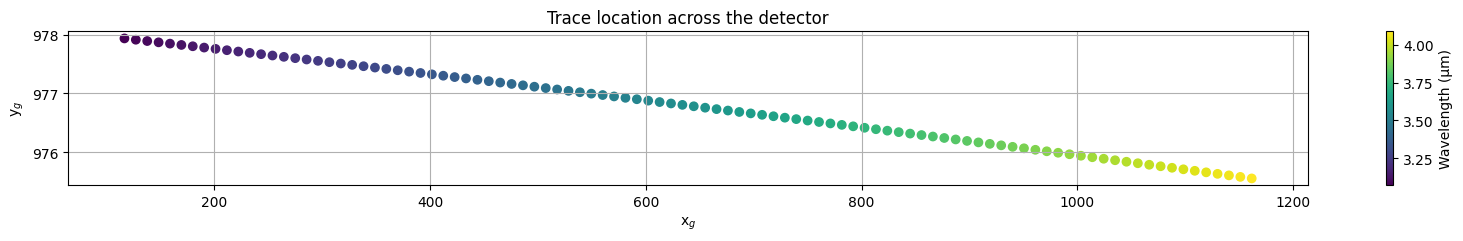

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 2))
plt.scatter(xgs, ygs, c=waves)
plt.colorbar(label="Wavelength (μm)")
plt.grid()
plt.ylabel(r"y$_g$")
plt.xlabel(r"x$_g$")
plt.title("Trace location across the detector")

### Basic Box Extraction

A very basic "extraction" of a spectrum can be performed using the WFSS transformation listed above. Here we show how one could perfrom a basic "Box" extraction of a well-isolated object i.e. not contaminated by overlapping spectra from other sources in the field).

One of the key concepts is the virtual location of the source in the dispersed WFSS observation. We are not able to determine that location precisely using the WFSS data alone and must rely on additional information. The location of the source is usually measured in a direct image of the field. In cases where the imaging and WFSS data are undithered with respect to one another, the position of the source in the WFSS observation is the position of the same source in the undithered imaging. 

If dithering was performed, one can rely on the WCS to estimate the location of the source in imaging data that would have been observed at the same position and orientation as the WFSS observation. This is done by computing the observed RA and Dec of the source in the available imaging data, and then converting these newly computed celestrial coordinates back to a detector ($x$, $y$) location using a WCS from the dithered WFSS observation.

#### Examine a source in the data

Look at a source in the imaging data

In [21]:
xd, yd = 1562, 696

Text(0, 0.5, 'Row Number')

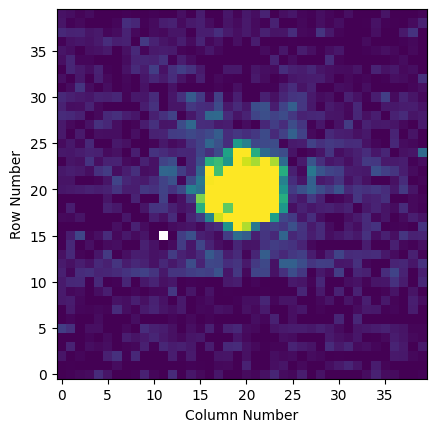

In [22]:
plt.imshow(imaging_data.data[yd - 20:yd + 20, xd - 20:xd + 20], origin="lower", vmin=0, vmax=10)
plt.xlabel('Column Number')
plt.ylabel('Row Number')

#### Calculate trace location

Now get the WCS from the imaging and WFSS files, so that we can perform coordinate transforms and calculate where the trace of this source lands in the WFSS observation.

In [23]:
imaging_to_world = imaging_data.meta.wcs.get_transform('detector', 'world')

In [24]:
wfss_to_pix = wfss_data.meta.wcs.get_transform('world', 'detector')

Translate the source's (x, y) location in the imaging mode data to RA, Dec, using the imaging mode WCS

In [25]:
ra, dec = imaging_to_world(xd, yd)
print(ra, dec)

247.88219867242918 30.177344115195204


Now translate the RA, Dec to a location on the detector in the WFSS data, using the WCS from the WFSS file. Note that for this translation, the wavelength and order are required inputs, but they do not actually affect the calculation. We'll use a wavelength of 3.56 microns and an order of 1 in the cell below, but you can see that changing these values does not change the resulting x, y values.

In [26]:
x, y, wav, ord = wfss_to_pix(ra, dec, 3.56, 1)
x, y, wav, ord

(1469.099441275972, 788.7595697184968, 3.56, 1.0)

Compute an approximate bounding box for the spectrum of this source. We use the fact that calibration define the edges of the spectra at values of t=0 and t=1 in the dispersion direction

In [27]:
# First calculate the distance from the nominal x, y location to the left and right
# edges of the box (i.e. where t = 0 and t = 1)
ts = np.array([0, 1])
dxs = C.DISPX("+1", x, y, ts)
dys = C.DISPY("+1", x, y, ts)
dxs, dys

(array([-883.466135,  172.310757]), array([-22.1331499 , -24.47802543]))

In [28]:
# Use the distances above to calculate the x location of the left and right edges of the box.
x_min = int(x + dxs[0])
x_max = int(x + dxs[1])

# Set the height of the box to be 50 pixels (25 pixels above and below the nominal location
y_min = int(y + dys[1] - 25)
y_max = int(y + dys[1] + 25)

x_min, x_max

(585, 1641)

Show an image of the box to be extracted.

Text(0, 0.5, 'Row Number')

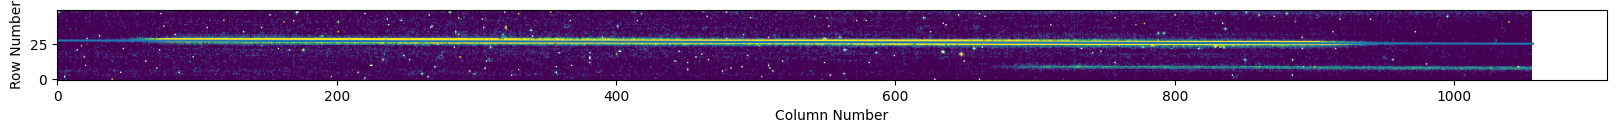

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.imshow(wfss_data.data[y_min:y_max, x_min:x_max], origin="lower", vmin=0.25, vmax=1)

ax.plot(x+dxs-x_min, y+dys-y_min)
ax.set_xlabel('Column Number')
ax.set_ylabel('Row Number')

The simplest extraction can be done under the assumption that the spectral trace is essentially linear and that the wavelength of the light falling on a pixel is only a function of the dispersion direction. As such, we can use the approximation that all pixels in a column correspond to the same wavelength. This is only appropriate for nearly flat dispersions and has often been assumed in the past. This also assumes that the field dependence of the dispersion is small within the area covered by a spectrum.

 #### Estimate Background

Here, for this simplest case, we estimate and subtract a simple background value from the data, taken to be the median value in the region contianing our spectrum. This very simple step illustrates the limits of simple box extraction as any such estimate will be biased by any other sources in the field, or any non-flatness in the structure of the dispersed background. 

In [30]:
# We want to ignore all NaN pixels, so locate all non-NaN pixels
ok = np.isfinite(wfss_data.data[y_min:y_max, x_min:x_max])

# Sigma-clip the pixels in the box
clipped, low, upp = sigmaclip(wfss_data.data[y_min:y_max, x_min:x_max][ok], 1.5, 1.5)

# Calculate the median of the sigma-clipped pixels
med_bck = np.nanmedian(clipped)
print("Background level estimate:", med_bck)

Background level estimate: 0.22513774


Text(0, 0.5, 'Occurrences')

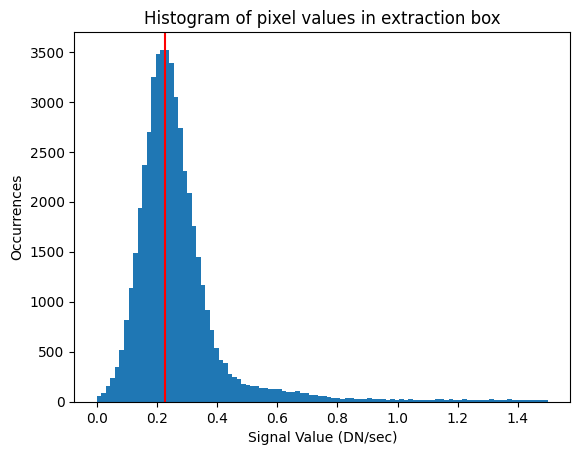

In [31]:
# Plot a histogram of the data, along with a line indicating the median level
plt.hist(np.ravel(wfss_data.data[y_min:y_max, x_min:x_max]), 100, range=(0, 1.5))
plt.axvline(med_bck, color='r')
plt.title('Histogram of pixel values in extraction box')
plt.xlabel('Signal Value (DN/sec)')
plt.ylabel('Occurrences')

#### Assign Wavelengths

Compute the wavelength everywhere on the array for this object. We use the full array here for simplicity and compute the distance in the x- direction (dispersion direction) between a pixel and the source.

In [32]:
ys, xs = np.indices(np.shape(wfss_data.data))

Translate the x values to be distances from the nominal source location

In [33]:
dxs = xs - x

We use the grismconf relations to compute the $t$ values everywhere and then compute the wavelengths, again everywhere.

In [34]:
ts = C.INVDISPX("+1", x, y, dxs)
lams = C.DISPL("+1", x, y, ts)

Displaying the wavelength array on the same area on the detector where the spectrum is, we see what we now have a wavelength estimate for each element of the 2D WFSS data.

Text(0, 0.5, 'Row Number')

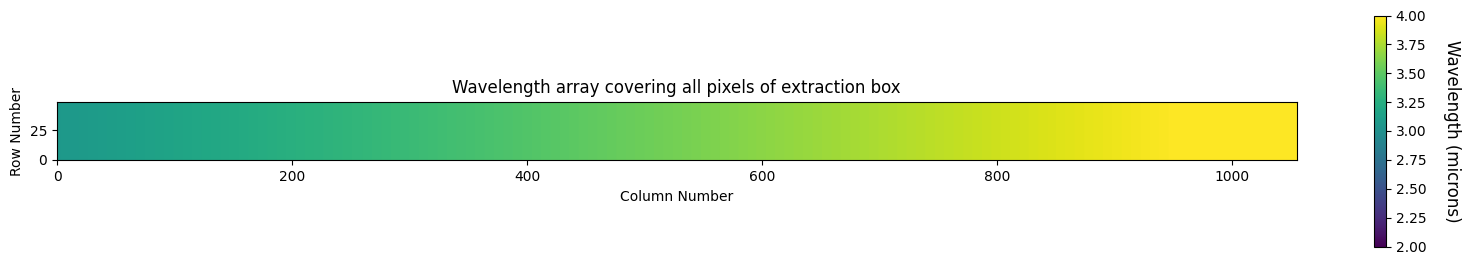

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
tt = ax.imshow(lams[y_min:y_max, x_min:x_max], origin="lower", vmin=2, vmax=4)
cbar = plt.colorbar(tt).ax.set_ylabel('Wavelength (microns)', rotation=270, fontsize=12, labelpad=25)
plt.title('Wavelength array covering all pixels of extraction box')
plt.xlabel('Column Number')
plt.ylabel('Row Number')

#### Box extraction

Creating a 1D spectrum from the data above is, in its simplest form, a matter of collapsing things along the cross dipsersion direction (y- direction). The 1D spectrum will be affected by bad pixels, any spectra contamination, as well as any error in the amount of background subtracted. These effects become increasingly important as the box size is increased. We also subtract the median background from each column.

Text(0.5, 1.0, 'Extracted 1D spectrum versus detector column')

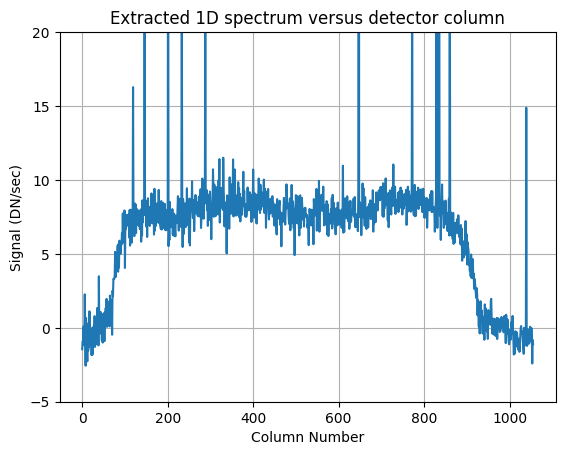

In [36]:
cs = np.nansum(wfss_data.data[y_min:y_max, x_min:x_max] - med_bck, axis=0)
plt.plot(cs)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('Column Number')
plt.ylabel('Signal (DN/sec)')
plt.title('Extracted 1D spectrum versus detector column')

#### Wavelength calibration

In this case, we can average the wavelength array in the cross dispersion direction (y-direction) to obtain a single wavelength vector that is appropriate for the spectum we just box extracted. Plotting the 1D count vector versus the wavelength vector thus created results in a wavelength calibrated 1D spectrum

Text(0.5, 1.0, 'Extracted 1D spectrum versus wavelength')

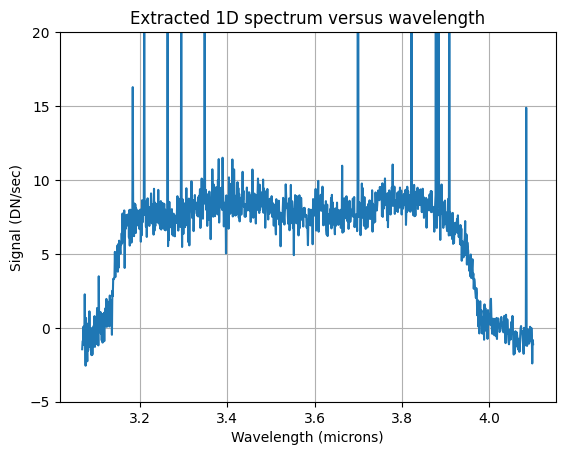

In [37]:
ws = np.nanmean(lams[y_min:y_max, x_min:x_max], axis=0)
plt.plot(ws, cs)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('Wavelength (microns)')
plt.ylabel('Signal (DN/sec)')
plt.title('Extracted 1D spectrum versus wavelength')

#### Converting to physical units

Here we use information contained in grismconf to convert our 1D spectrum, which is in units of DN/sec (per bin, or pixel in this case since there is no resampling of the data) into units of $erg / sec / cm^2 / \overset{\circ}{A}$. The grism inverse sensitivity curve in grismconf is in units of DN/sec (per pixel) per $erg / sec / cm^2 / \overset{\circ}{A}$. As the sensitivity is defined per Angstrom while our 1D spectrum is extracted per pixel, we need to account for this when applying the sensitivity. In most WFSS data the variation of the pixel size in wavelength units is small but this can easily be accounted for by computing the size of each pixel in wavelength units (Angstrom) as we show below.

Text(0.5, 1.0, 'Inverse sensitivity curve')

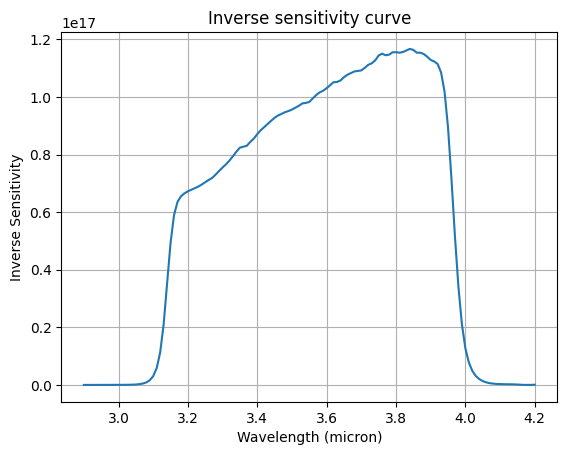

In [38]:
# Plot the inverse sensitivity curve
tws = np.arange(2.9, 4.2, 0.01)
plt.plot(tws, C.SENS["+1"](tws))
plt.grid()
plt.xlabel("Wavelength (micron)")
plt.ylabel("Inverse Sensitivity")
plt.title("Inverse sensitivity curve")

Calculate the size of each element in our 1D spectrum, in Angstrom

In [39]:
# The value of 10000 comes from the NIRCam dispersion value of ~10A per pixel
dws = (ws[1:] - ws[:-1]) * 10000

Apply the sensitivity curve by dividing the 1D counts by the sensitivity and by the size of each bin in Angstrom to produce flux values in units of $erg / sec / cm^2 / \overset{\circ}{A}$

In [40]:
fs = cs[1:] / C.SENS["+1"](ws[1:]) / dws

Plotting the resulting flux array versus our wavelength scale shows the fully calbirated 1D spectrum. One caveat of the conversion from DN/sec per pixel to $erg / sec / cm^2 / \overset{\circ}{A}$ is the well known edge effect caused by dividing counts values that are zero or close to zero by the sensitivity. As this method does not account for the broadening of the spectra by the footprint of the object in the dispersion direction, this effect is worse for extended sources. This effect can only be mitigated by more forward modeling extraction methods.

Text(0.5, 1.0, 'Extracted 1D spectrum in $F_{lambda}$ units')

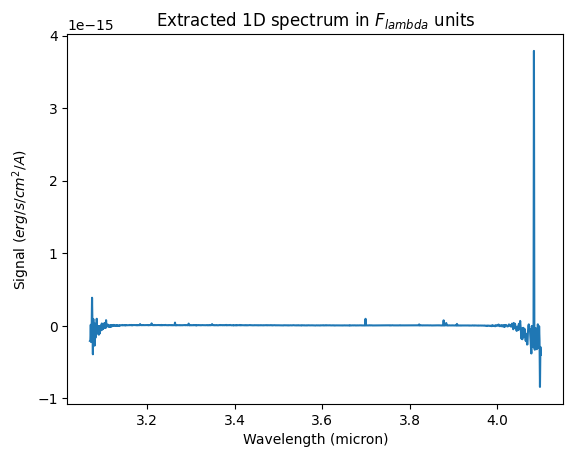

In [41]:
plt.plot(ws[1:], fs)
plt.xlabel("Wavelength (micron)")
plt.ylabel("Signal ($erg/s/cm^2/A$)")
plt.title("Extracted 1D spectrum in $F_{lambda}$ units")

Concentrating on regions off the spectral edges reveals the spectrum of our source. One of the many drawbacks of this simplistic box extraction method is the impact of bad pixels and any residual cosmic rays. These can cause significnat peaks in the spectra, which can be confused for emission lines.

Text(0.5, 1.0, 'Extracted 1D spectrum in $F_{lambda}$ units')

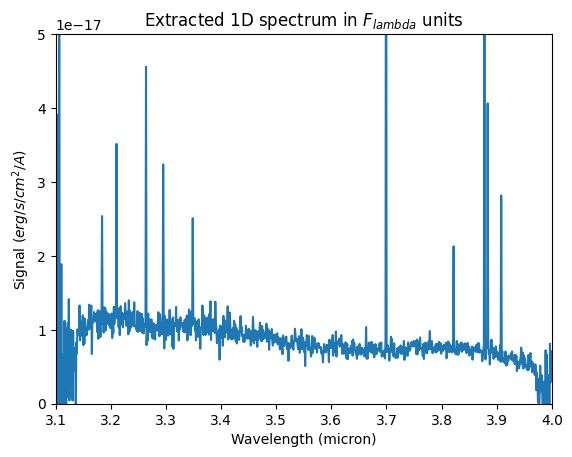

In [42]:
plt.plot(ws[1:], fs)
plt.xlim(3.1, 4.)
plt.ylim(0, 0.5e-16)
plt.xlabel("Wavelength (micron)")
plt.ylabel("Signal ($erg/s/cm^2/A$)")
plt.title("Extracted 1D spectrum in $F_{lambda}$ units")